In [138]:
#!kaggle competitions download -c nlp-getting-started

In [139]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [140]:
train = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/train.csv")
test = pd.read_csv("/Users/reejungkim/Documents/Git/Sentimental analysis/nlp-getting-started/test.csv")

In [141]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [142]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [168]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [169]:
train.shape, test.shape, df.shape

((7613, 5), (3263, 4), (10876, 5))

In [177]:
df.tail()

,id,keyword,location,text,target
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [178]:
not_disaster = df.loc[df.target==0]
disaster = df.loc[df.target==1]

In [183]:
for i in range(0, 10):
    print(i ,". ", disaster.text[i], "target: ",disaster.target[i] ) 

0 .  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all target:  1.0
1 .  Forest fire near La Ronge Sask. Canada target:  1.0
2 .  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected target:  1.0
3 .  13,000 people receive #wildfires evacuation orders in California  target:  1.0
4 .  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  target:  1.0
5 .  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires target:  1.0
6 .  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas target:  1.0
7 .  I'm on top of the hill and I can see a fire in the woods... target:  1.0
8 .  There's an emergency evacuation happening now in the building across the street target:  1.0
9 .  I'm afraid that the tornado is coming to our area... target:  1.0


In [184]:
disaster.loc[pd.notnull(disaster.keyword)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


In [185]:
disaster.loc[pd.notnull(disaster.location)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


# Feature engineering

In [186]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [187]:
df['url']= df['text'].apply(lambda x:find_url(x))
df.loc[pd.notnull(df.url)]

,id,keyword,location,text,target,url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0,http://t.co/lHYXEOHY6C
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0.0,http://t.co/YAo1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0,http://t.co/2nndBGwyEi
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,http://t.co/qqsmshaJ3N
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0,http://t.co/3ImaomknnA
...,...,...,...,...,...,...
10865,10836,NaN,NaN,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,NaN,http://t.co/tjpYlU9fOX
10866,10838,NaN,NaN,Malaysian PM confirms debris is from missing f...,NaN,http://t.co/pfAvW5QyqE
10868,10856,NaN,NaN,See the 16yr old PKK suicide bomber who detona...,NaN,http://t.co/hKuT5mSdtP
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,http://t.co/UtbXLcBIuY


In [188]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

extract_emojis("😘😳😍test")

'😘😳😍'

In [190]:
df['emoji']= df['text'].apply(lambda x: extract_emojis(x))

In [191]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [193]:
df.text = df.text.apply(lambda x: remove_emoji(x))

In [194]:
stops = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [195]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)
    

In [196]:
df['text processed'] = df['text'].apply(lambda x: language_preprocessor(x)) 

In [197]:
df.head(3)

,id,keyword,location,text,target,url,emoji,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,None,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,None,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,None,None,"[resident, asked, shelter, place, notified, of..."


In [198]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

In [199]:
disaster_common_words  = common_words(train.loc[train.target==1], 'text processed', 50)
disaster_common_words.head(5)

KeyError: 'text processed'

In [200]:

words = disaster_common_words.set_index("Word")['count'].to_dict()


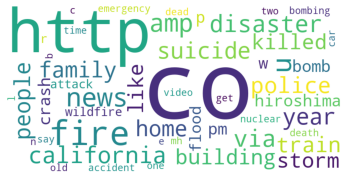

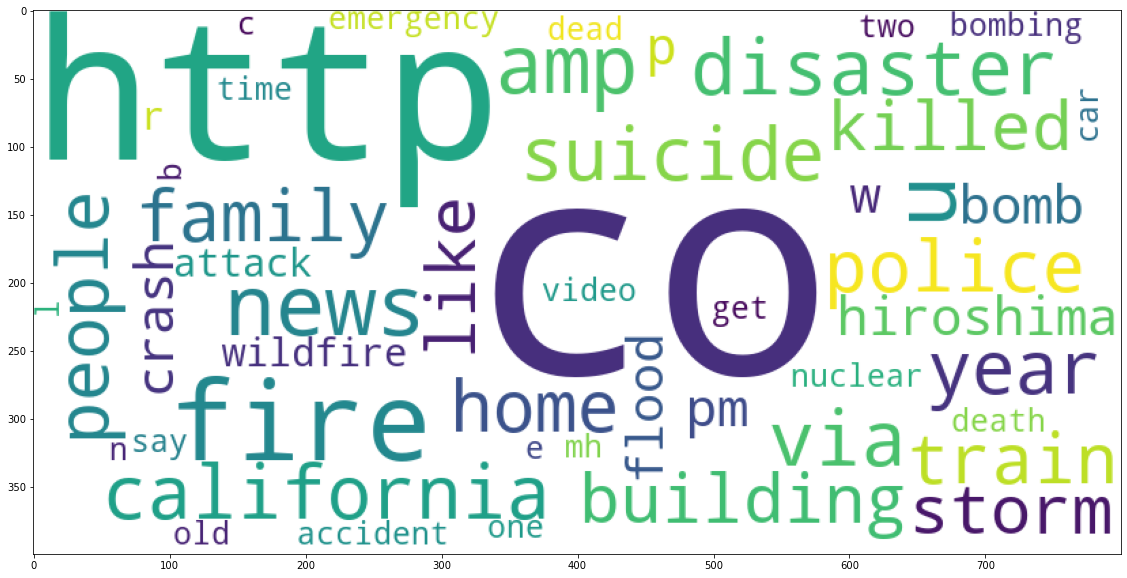

In [201]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white',width=800, height=400)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.show()


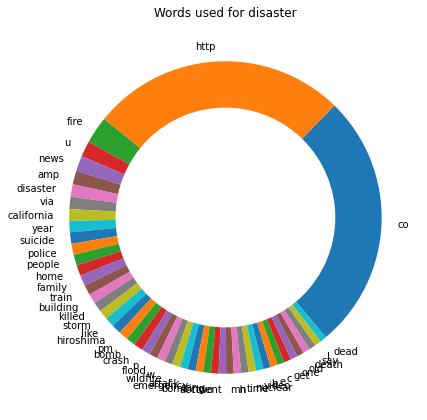

In [202]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(7,10))
my_circle=plt.Circle((0,0), 0.7, color='white')

plt.pie(disaster_common_words['count'], 
        labels=disaster_common_words.Word, startangle=-50) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Words used for disaster')
plt.show()
